# Loading Dataset and Merging

In [1]:
import pandas as pd
import re
import os

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/princessventures/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/princessventures/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
dataset_path = '../dataset'

dataframes = []

for filename in os.listdir(dataset_path):
    if filename.endswith('.csv'):
        
        file_path = os.path.join(dataset_path, filename)
       
        parts = filename.split('_')
        subreddit_name = parts[1]
        search_input = parts[2]
        
        df = pd.read_csv(file_path, parse_dates=['created'], dtype={
            'title': 'string', 'body': 'string', 'link': 'string', 
            'author': 'string', 'upvotes': 'int64'
        })
        
        df['subreddit'] = subreddit_name
        df['search_input'] = search_input
        
        if not df.empty and not df.isna().all().all():
            dataframes.append(df)

if dataframes:
    combined_df = pd.concat(dataframes, ignore_index=True)
else:
    print("No valid CSV files found or all files are empty.")

In [3]:
combined_df.head()

,title,body,link,author,created,upvotes,num_comments,subreddit,search_input
0,"I don't care if you're a girl, unsolicited pic...","So like many of the people on this subreddit, ...",https://www.reddit.com/r/alasjuicy/comments/10...,t2_uzp1eor9,2023-01-10 18:35:34,126,20,alasjuicy,unsolicited pics
1,Unsolicited Dick Pics Enjoyer,Bago lang ako naging active dito sa AJ. Mostly...,https://www.reddit.com/r/alasjuicy/comments/1a...,t2_9x1nt0ze2,2024-02-08 03:58:45,68,54,alasjuicy,unsolicited pics
2,UNSOLICITED DICK PIC,Hello men of aj! Eto sakin lang ah. Para saki...,https://www.reddit.com/r/alasjuicy/comments/18...,t2_q6lir5af,2023-11-27 19:50:18,84,59,alasjuicy,unsolicited pics
3,Unsolicited d!ck pics,it really irks me knowing na ang dami pa ring ...,https://www.reddit.com/r/alasjuicy/comments/1c...,t2_ssss4d1u,2024-04-16 23:39:01,17,36,alasjuicy,unsolicited pics
4,Kelan ba titigil unsolicited dick pic?,"Pakiusap naman, di porket nagpost ako dito kah...",https://www.reddit.com/r/alasjuicy/comments/1b...,t2_xb6pbdoh7,2024-04-03 18:35:41,45,46,alasjuicy,unsolicited pics


In [4]:
combined_df.shape

(1921, 9)

In [5]:
combined_df.describe()

,created,upvotes,num_comments
count,1921,1921.000000,1921.000000
mean,2022-07-19 09:35:59.136908032,70.358147,27.482041
min,2013-08-07 01:22:56,0.000000,0.000000
25%,2022-01-01 09:27:02,2.000000,2.000000
50%,2023-04-19 11:03:04,8.000000,7.000000
75%,2023-11-25 23:58:54,37.000000,23.000000
max,2024-04-17 09:44:55,4945.000000,1440.000000
std,NaN,243.546844,78.961560


In [6]:
combined_df.count()

title           1921
body            1731
link            1921
author          1921
created         1921
upvotes         1921
num_comments    1921
subreddit       1921
search_input    1921
dtype: int64

In [7]:
combined_df['subreddit'].unique()

array(['alasjuicy', 'OffmychestPH', 'relationship advicePH',
       'MentalHealthPH', 'Philippines'], dtype=object)

In [8]:
combined_df['search_input'].unique()

array(['unsolicited pics', 'abused', 'emotional abuse', 'Cyberbullying',
       'stalking', 'physical abuse', 'domestic violence',
       'sexual harassment'], dtype=object)

# Pre-processing Steps

In [9]:
combined_df.isnull().sum()

title             0
body            190
link              0
author            0
created           0
upvotes           0
num_comments      0
subreddit         0
search_input      0
dtype: int64

In [10]:
combined_df.dropna(subset=['body'], inplace=True)

In [11]:
def find_age_gender(text):
    matches = re.findall(r'\b(\d{2}\s?[MF])\b', text.upper())
    return matches

combined_df['age_gender'] = combined_df['body'].apply(find_age_gender)

In [12]:
def remove_mentions_and_urls(text):
    url_pattern = r'https?://\S+|www\.\S+'
    subreddit_pattern = r'\br/\w+'

    
    text = re.sub(url_pattern, '', text)
    text = re.sub(subreddit_pattern, '', text)
    text = re.sub(r'\[([^\]]+)\]\(\)', r'\1', text)

    return text

combined_df['body'] = combined_df['body'].apply(remove_mentions_and_urls)

In [13]:
# text tokenization and stop words removal

stop_words = set(stopwords.words('english'))

def tokenize_and_remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    return filtered_words

In [14]:
combined_df['title'] = combined_df['title'].apply(tokenize_and_remove_stopwords)
combined_df['body'] = combined_df['body'].apply(tokenize_and_remove_stopwords)

In [15]:
# feature engineering

# extract year, month, day from the 'created' column
combined_df['year'] = combined_df['created'].dt.year
combined_df['month'] = combined_df['created'].dt.month
combined_df['day'] = combined_df['created'].dt.day

In [16]:
# calculate post length
combined_df['post_length'] = combined_df['body'].apply(len)

In [17]:
# calculate day of the week and other time-related features
combined_df['day_of_week'] = combined_df['created'].dt.dayofweek
combined_df['is_weekend'] = combined_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
combined_df['time_of_day'] = pd.cut(combined_df['created'].dt.hour, 
                                   bins=[0, 6, 12, 18, 24], 
                                   labels=['Night', 'Morning', 'Afternoon', 'Evening'], 
                                   right=False)

In [18]:
# relative_upvotes
# normalize upvotes by the average upvotes per month to see if certain posts got unusually high engagement
monthly_avg_upvotes = combined_df.groupby('month')['upvotes'].transform('mean')
combined_df['upvotes_relative'] = combined_df['upvotes'] / monthly_avg_upvotes

In [19]:
membership_sizes = {
    'alasjuicy': 247000,
    'OffmychestPH': 493000,
    'relationship advicePH': 130000,
    'MentalHealthPH': 46000,
    'Philippines': 1700000
}

combined_df['subreddit_size'] = combined_df['subreddit'].map(membership_sizes)

In [20]:
combined_df['upvotes_per_capita'] = combined_df['upvotes'] / combined_df['subreddit_size']

In [21]:
combined_df['age_gender']

0       []
1       []
2       []
3       []
4       []
        ..
1916    []
1917    []
1918    []
1919    []
1920    []
Name: age_gender, Length: 1731, dtype: object

# PH Holidays

In [22]:
data = {
    'Date': ['01-01', '03-28', '03-29', '04-09', '05-01', '06-12', '08-26', '11-30', '12-25', '12-30', 
             '04-10', '08-21', '11-01', '12-08', '12-31', '02-09', '02-10', '03-30', '11-02', '12-24', '03-01'],
    'Holiday': ['New Year\'s Day', 'Maundy Thursday', 'Good Friday', 'Araw ng Kagitingan', 'Labor Day', 
                'Independence Day', 'National Heroes Day', 'Bonifacio Day', 'Christmas Day', 'Rizal Day', 
                'Eid\'l Fitr', 'Ninoy Aquino Day', 'All Saints\' Day', 'Feast of the Immaculate Conception of Mary', 
                'Last Day of the Year', 'Additional Special (Non-Working) Day', 'Chinese New Year', 'Black Saturday', 
                'All Souls\' Day', 'Christmas Eve', 'Women\'s Month Start'],
    'Type': ['Regular', 'Regular', 'Regular', 'Regular', 'Regular', 'Regular', 'Regular', 'Regular', 'Regular', 
             'Regular', 'Regular', 'Special Non-Working', 'Special Non-Working', 'Special Non-Working', 
             'Special Non-Working', 'Special Non-Working', 'Special Non-Working', 'Special Non-Working', 
             'Special Non-Working', 'Special Non-Working', 'Special Non-Working']
}

holidays_df = pd.DataFrame(data)

holidays_df


,Date,Holiday,Type
0,01-01,New Year's Day,Regular
1,03-28,Maundy Thursday,Regular
2,03-29,Good Friday,Regular
3,04-09,Araw ng Kagitingan,Regular
4,05-01,Labor Day,Regular
5,06-12,Independence Day,Regular
6,08-26,National Heroes Day,Regular
7,11-30,Bonifacio Day,Regular
8,12-25,Christmas Day,Regular
9,12-30,Rizal Day,Regular


In [23]:
holidays_df.to_csv('ph_holidays.csv', index=False)

# Extracting relationship from text

In [24]:
import subprocess
import sys

def install_packages():
    subprocess.check_call([sys.executable, "-m", "pip", "install", "spacy"])

    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])

try:
    import spacy
    nlp = spacy.load("en_core_web_sm")
    
except OSError:
    install_packages()
    import spacy
    nlp = spacy.load("en_core_web_sm")

In [25]:
from spacy.matcher import Matcher

nlp = spacy.load("en_core_web_sm")
matcher = Matcher(nlp.vocab)

In [26]:
relationship_patterns = {
    'family': [
        [{"LOWER": word}] for word in ['mother', 'father', 'sister', 'brother', 'sibling', 'nanay', 'tatay', 'kuya', 'ate', 'kapatid', 
                                       'lola', 'lolo', 'grandmother', 'grandfather', 'cousin', 'pinsan', 'tito', 'tita', 'uncle', 'aunt']
    ],
    'partner': [
        [{"LOWER": word}] for word in ['husband', 'wife', 'boyfriend', 'girlfriend', 'bf', 'gf', 'asawa', 'jowa', 'so', 'partner', 
                                       'spouse', 'misis', 'mister', 'fiance', 'fiancee', 'kasintahan', 'syota', 'live-in', 'livein']
    ],
    'classmate': [
        [{"LOWER": word}] for word in ['classmate', 'kaklase', 'schoolmate', 'seatmate', 'batchmate', 'school friend']
    ],
    'acquaintance': [
        [{"LOWER": word}] for word in ['friend', 'neighbor', 'colleague', 'workmate', 'kaibigan', 'kapitbahay', 'kasamahan', 'boss', 
                                       'supervisor', 'manager', 'co-worker', 'barkada', 'comrade', 'kabarkada', 'amigo', 'amiga']
    ],
    'stranger': [
        [{"LOWER": word}] for word in ['stranger', 'unknown person', 'di kilala', 'unknown', 'outsider', 'foreigner', 'bystander']
    ]
}

In [27]:
for label, patterns in relationship_patterns.items():
    matcher.add(label, patterns)

def extract_relationship(text):
    doc = nlp(text.lower())
    matches = matcher(doc)
    if matches:
        match_id, start, end = max(matches, key=lambda x: x[1]-x[2])
        return nlp.vocab.strings[match_id]
    return 'unknown'

In [28]:
combined_df['body_text'] = combined_df['body'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
combined_df['relationship'] = combined_df['body_text'].apply(extract_relationship)

In [29]:
combined_df.to_csv('preprocessed_dataset.csv', index=False)

# Train model and evaluate

In [30]:
encoder = OneHotEncoder()
relationship_encoded = encoder.fit_transform(combined_df[['relationship']])

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
text_features = tfidf_vectorizer.fit_transform(combined_df['body_text'])

from scipy.sparse import hstack
X = hstack([text_features, relationship_encoded])

y = combined_df['search_input']


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))


Accuracy: 0.4576923076923077
Classification Report:
                    precision    recall  f1-score   support

    Cyberbullying       0.21      0.40      0.28        10
           abused       0.49      0.33      0.39       118
domestic violence       0.55      0.48      0.51        25
  emotional abuse       0.25      0.26      0.26        92
   physical abuse       0.34      0.33      0.34        99
sexual harassment       0.59      0.64      0.61        64
         stalking       0.63      0.76      0.69       102
 unsolicited pics       0.54      0.70      0.61        10

         accuracy                           0.46       520
        macro avg       0.45      0.49      0.46       520
     weighted avg       0.46      0.46      0.45       520



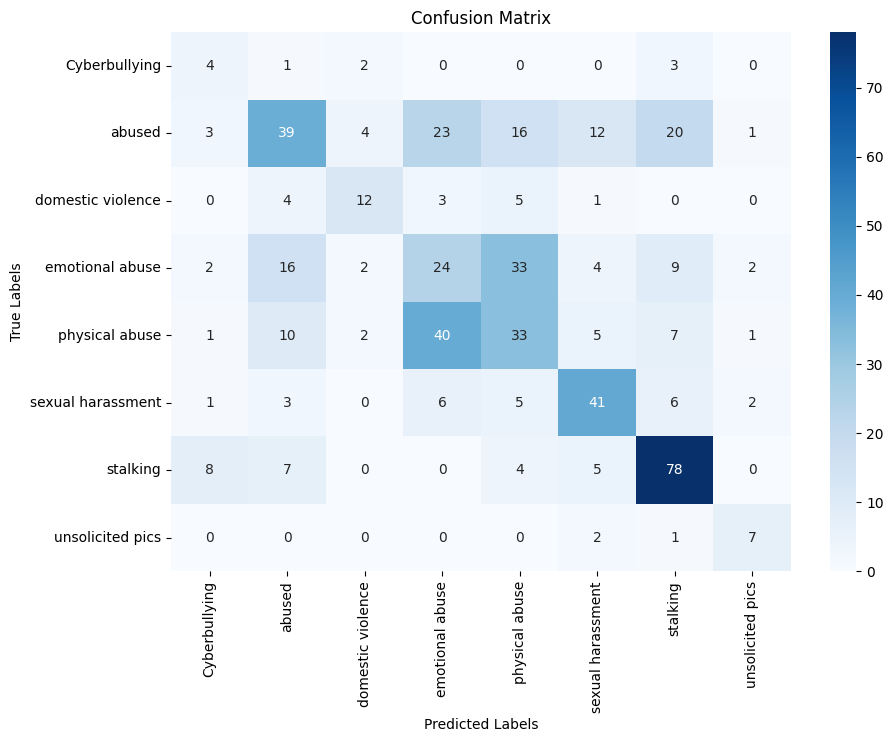

In [32]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
